Part 2
Data Analysis

Due to the large size of the data, only one month's records for both yellow taxi and green taxi were used. The data set was built by combining the yellow taxi data and the green taxi data for January 2016 as decribed in Part 1. The data should give reasonable generalization power, as it was presented in an article that there is no big seasonal trend on taxi demand (http://sdaulton.github.io/TaxiPrediction/).

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from scipy import stats

Read the preprocessed data

In [5]:
trip_data = pd.read_csv('trip_data_yellow+green_2016_1.csv')
date_columns = ['pickup_datetime', 'dropoff_datetime']
for col in date_columns:
       trip_data[col] = pd.to_datetime(trip_data[col])

Add new features: pickup hour, pickup day of month, pick day of week

In [11]:
data = trip_data.copy()
data = data.drop('Unnamed: 0', axis=1)
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday_name

In [12]:
print(data.shape)
print(data.columns)

(8140614, 9)
Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'total_amount', 'pickup_neighbourhood', 'dropoff_neighbourhood',
       'pickup_day', 'pickup_hour', 'pickup_weekday'],
      dtype='object')


There are 8140614 records, and 9 features. Total_amount holds fare values. The statistics of the data seem reasonable as shown below.

In [13]:
data.describe()

,passenger_count,total_amount,pickup_day,pickup_hour
count,8.140614e+06,8.140614e+06,8.140614e+06,8.140614e+06
mean,1.667483e+00,1.295051e+01,1.600908e+01,1.362731e+01
std,1.325459e+00,8.211994e+00,8.840804e+00,6.280575e+00
min,1.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00
25%,1.000000e+00,8.150000e+00,9.000000e+00,9.000000e+00
50%,1.000000e+00,1.080000e+01,1.600000e+01,1.400000e+01
75%,2.000000e+00,1.480000e+01,2.300000e+01,1.900000e+01
max,6.000000e+00,2.000000e+02,3.100000e+01,2.300000e+01


Define Aliases and areas of three neighborhoods of interest

In [14]:
a = 'Astoria'
aa = 902.94 # acres
g = 'Greenpoint'
ga = 809.13 # acres
u = 'Upper East Side' # actually includes yorkhill and Lenox Hill
ua = 1126.4 # acres

To evaluate the efficiency of ride, the metric "passenger count per acre" is used. But first, let's check how many passengers were picked up in each neighborhood in this month.

Picked up passenger count in Astoria: 62001


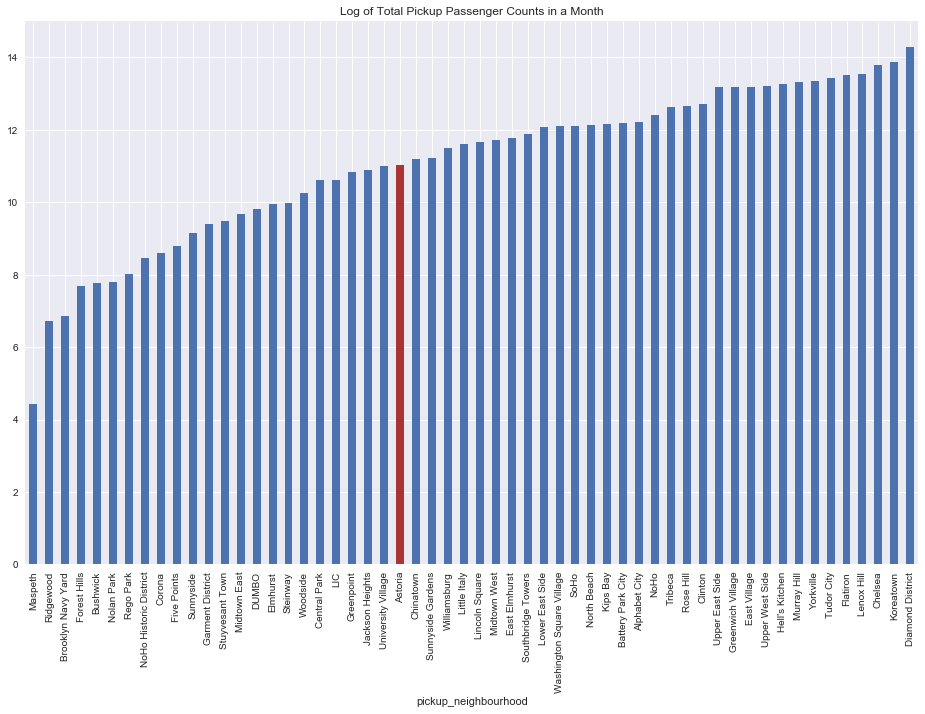

In [33]:
total_passenger = data.groupby('pickup_neighbourhood')['passenger_count'].sum()
print('Picked up passenger count in Astoria: %d' % total_passenger[a])
total_passenger = np.log(total_passenger.sort_values())
plt.figure(figsize=(16,10))
ax = total_passenger.plot(kind='bar')
pos = total_passenger.index.get_loc(a)
ax.patches[pos].set_facecolor('#aa3333')
plt.title('Log of Total Pickup Passenger Counts in a Month')

The number of picked up passenger of this month in Astoria is 62001. It is larger than several other neighborhoods. I will compare Astoria with Greenpoint in the following analysis.
It makes more sense if we consider passenger density instead of total number in some neighborhood. The following plot shows the daily picked up passenger density (passenger count/acre) for Astoria and Greenpoint, and it indicates that Astoria may have better efficiency of shared ride service.

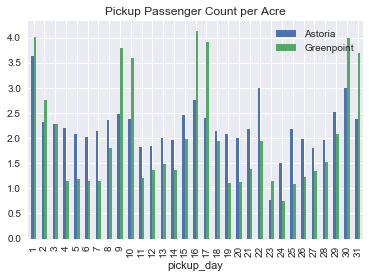

In [36]:
pickup_count = data.groupby(['pickup_neighbourhood', 'pickup_day'])['passenger_count'].sum()
ax = pd.DataFrame({a: pickup_count[a]/aa, g: pickup_count[g]/ga}).plot(kind='bar')
plt.title('Pickup Passenger Count per Acre')

The above plots are about picked up passengers in a certain neighborhood. Now let's check rides within Astoria.

In [56]:
# This function finds all records that picked up passenger in nbh1 and dropped off in nbh2
def passenger_count(nbh1, nbh2):
       # From nbh1 to nbh2
       pickup_index = np.array([True if val in nbh1 else False for val in data['pickup_neighbourhood']])
       dropoff_index = np.array([True if val in nbh2 else False for val in data['dropoff_neighbourhood']])
       df = data[pickup_index & dropoff_index]
       df = df.groupby('pickup_weekday')['passenger_count'].sum()
       return df

Total passenger count within Astoria: 16389
Total passenger count within Greenpoint: 11238


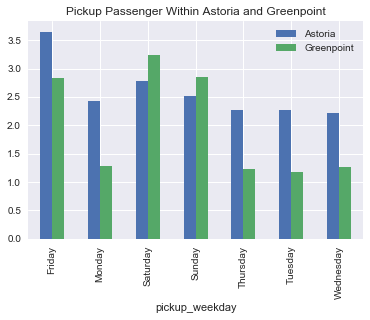

In [78]:
data_aa = passenger_count(a,a)
data_gg = passenger_count(g,g)
ax = pd.DataFrame({a: data_aa/aa, g: data_gg/ga}).plot(kind='bar')
plt.title('Pickup Passenger Within Astoria and Greenpoint')

print('Total passenger count within Astoria: %d' % data_aa.sum())
print('Total passenger count within Greenpoint: %d' % data_gg.sum())

The above plot shows that passenger density traveled within Astoria is larger than that in Greenpoint, although the passenger densities in Greenpoint during weekends are larger. Next, let's check the passenger count from Astoria to Manhattan, and between Manhattan and LGA. First define collections of neighborhoods that constitue Manhattan and LGA.

In [58]:
lga = ['East Elmhurst', 'North Beach']
manhattan = ['NoHo Historic District', 'Five Points', 'Garment District', 'Stuyvesant Town',
                            'Midtown East', 'Central Park', 'University Village', 'Chinatown','Little Italy',
                            'Lincoln Square', 'Midtown West', 'Southbridge Towers', 'Lower East Side', 'SoHo',
                            'Washington Square Village', 'Kips Bay', 'Battery Park City', 'Alphabet City', 'NoHo',
                            'Tribeca', 'Rose Hill', 'Clinton', 'Upper East Side', 'Greenwich Village', 'East Village',
                            'Upper West Side', "Hell's Kitchen", 'Murray Hill', 'Yorkville', 'Tudor City', 'Flatiron',
                            'Lenox Hill', 'Chelsea', 'Koreatown', 'Diamond District']

Total passenger from Astoria to Manhattan: 14043
Total passenger from Greenpoint to Manhattan: 15894


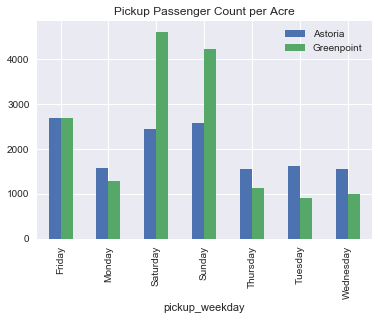

In [62]:
data_astoria_manhattan = passenger_count(a, manhattan)
data_greenpoint_manhattan = passenger_count(g, manhattan)
ax = pd.DataFrame({a: data_astoria_manhattan, g: data_greenpoint_manhattan}).plot(kind='bar')
plt.title('Passenger Count to Manhattan')

print('Total passenger from Astoria to Manhattan: %d' % data_astoria_manhattan.sum())
print('Total passenger from Greenpoint to Manhattan: %d' % data_greenpoint_manhattan.sum())

Passenger count travelling from Astoria to Manhattan in one month is 14043, which is slightly smaller than that from Greenpoint. Note that there are significantly more people travelling from Greenpoint to Manhattan on weekends. Next let's check how many people travel from Manhattan to Astoria and Greenpoint.

Total passenger from Manhattan to Astoria: 36153
Total passenger from Manhattan to Greenpoint: 37309


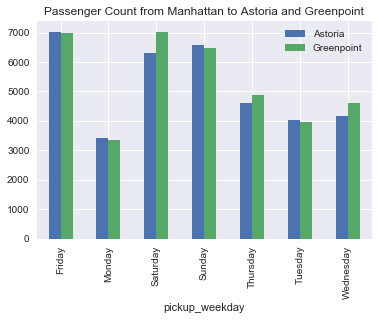

In [64]:
data_manhattan_astoria = passenger_count(manhattan, a)
data_manhattan_greenpoint = passenger_count(manhattan, g)
ax = pd.DataFrame({a: data_manhattan_astoria, g: data_manhattan_greenpoint}).plot(kind='bar')
plt.title('Passenger Count from Manhattan to Astoria and Greenpoint')

print('Total passenger from Manhattan to Astoria: %d' % data_manhattan_astoria.sum())
print('Total passenger from Manhattan to Greenpoint: %d' % data_manhattan_greenpoint.sum())

The number of people travelling from Manhattan to Astoria and Greenpoint are similar,and apparently there are more people travelling from Manhattan than to Manhattan. Next let's check how many people travel between Manhattan and LGA, and between Astoria and LGA.

Total passenger between Manhattan and LGA: 437142
Total passenger between Astoria to LGA: 7698


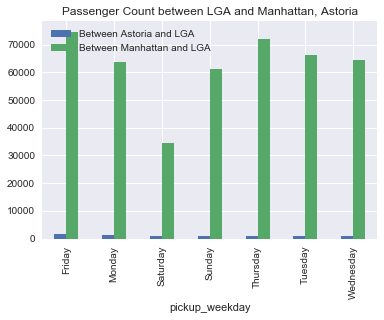

In [69]:
data_manhattan_lga = passenger_count(manhattan, lga) + passenger_count(lga, manhattan)
data_astoria_lga = passenger_count(a, lga) + passenger_count(lga, a)
ax = pd.DataFrame({'Between Astoria and LGA': data_astoria_lga, 'Between Manhattan and LGA': data_manhattan_lga}).plot(kind='bar')
plt.title('Passenger Count between LGA and Manhattan, Astoria')

print('Total passenger between Manhattan and LGA: %d' % data_manhattan_lga.sum())
print('Total passenger between Astoria to LGA: %d' % data_astoria_lga.sum())

When comparing with current area of service, there are several metrics to consider, such as passenger density, traffic, fare, gas price, licensing. Passenger density and traffic affect the efficiency, fare affects competitation with competitors and market share, gas price and licensing affect the revenue (of course all metrics here affect the revenue).

Total passenger within Astoria: 16389
Total passenger within Upper East Side: 60424


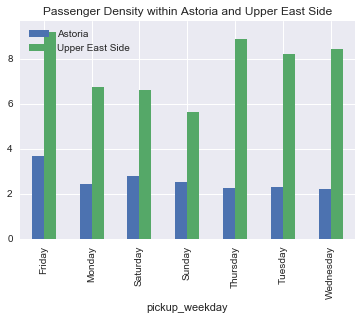

In [92]:
data_upper_east_side = passenger_count(u, u)
data_astoria = passenger_count(a, a)
ax = pd.DataFrame({a: data_astoria/aa, 'Upper East Side': data_upper_east_side/ua}).plot(kind='bar')
plt.title('Passenger Density within Astoria and Upper East Side')

print('Total passenger within Astoria: %d' % data_astoria.sum())
print('Total passenger within Upper East Side: %d' % data_upper_east_side.sum())

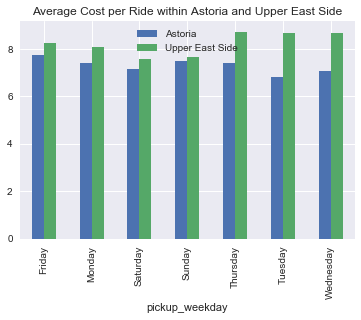

In [76]:
def passenger_average_fare(nbh1, nbh2):
       # From nbh1 to nbh2
       pickup_index = np.array([True if val in nbh1 else False for val in data['pickup_neighbourhood']])
       dropoff_index = np.array([True if val in nbh2 else False for val in data['dropoff_neighbourhood']])
       df = data[pickup_index & dropoff_index]
       df_count = df.groupby('pickup_weekday')['passenger_count'].count()
       df_fare = df.groupby('pickup_weekday')['total_amount'].sum()
       return df_fare/df_count

data_upper_east_side_cost = passenger_average_fare(u, u)
data_astoria_cost = passenger_average_fare(a, a)
ax = pd.DataFrame({a: data_astoria_cost, 'Upper East Side': data_upper_east_side_cost}).plot(kind='bar')
plt.title('Average Cost per Ride within Astoria and Upper East Side')

The passenger density in Astoria is less than 1/3 of that in Upper East Side as expected, and the average cost per ride is higher in Upper East Side. As the passenger density is much lower in Astoria, I expect the efficiency in terms of driven miles per passenger-mile would be lower in Astoria than in Upper East Side.

As previously shown, the total passenger number within Astoria is 16389 in a month, larger than that in Greenpoint. Let's check the passenger count between Astoria and Manhattan.

In [79]:
data_astoria_manhattan = passenger_count(a, manhattan) + passenger_count(manhattan, a)
print('Total passenger between Astoria and Manhattan: %d' % data_astoria_manhattan.sum())

Total passenger between Astoria and Manhattan: 50196


Passenger count between Astoria and Manhattan is more than triple passenger count within Astoria.

Let's plot the passenger count vs hour of the day for rides within Astoria.

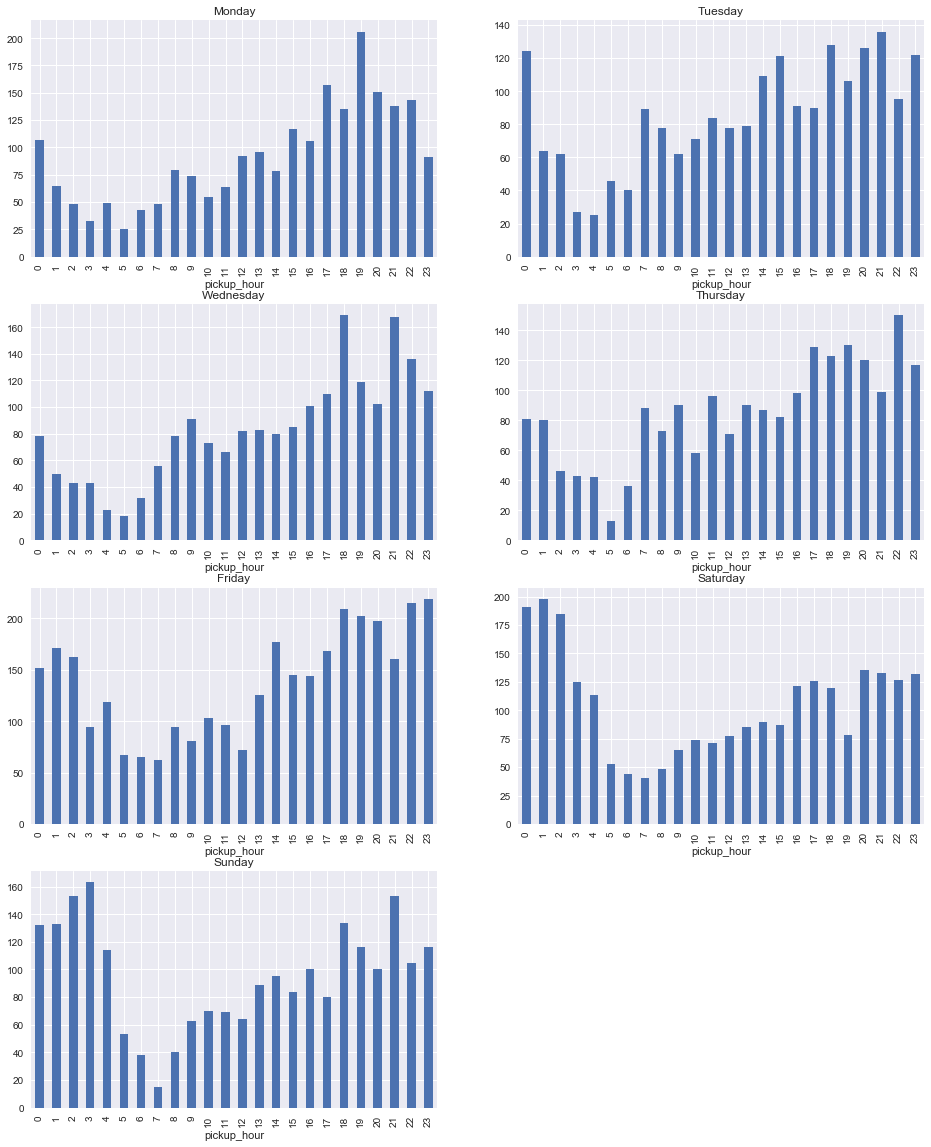

In [93]:
def passenger_count_hourly(nbh1, nbh2):
       # From nbh1 to nbh2
       pickup_index = np.array([True if val in nbh1 else False for val in data['pickup_neighbourhood']])
       dropoff_index = np.array([True if val in nbh2 else False for val in data['dropoff_neighbourhood']])
       df = data[pickup_index & dropoff_index]
       df = df.groupby(['pickup_weekday', 'pickup_hour'])['passenger_count'].sum()
       return df
data_astoria = passenger_count_hourly(a,a)
wd = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
f=plt.figure(figsize=(16,20))
for i in range(len(wd)):
    ax = f.add_subplot(4,2,i+1)
    ax = data_astoria[wd[i]].plot.bar()
    plt.title(wd[i])

Plot the passenger count vs hour of the day for rides between Astoria and Manhattan.

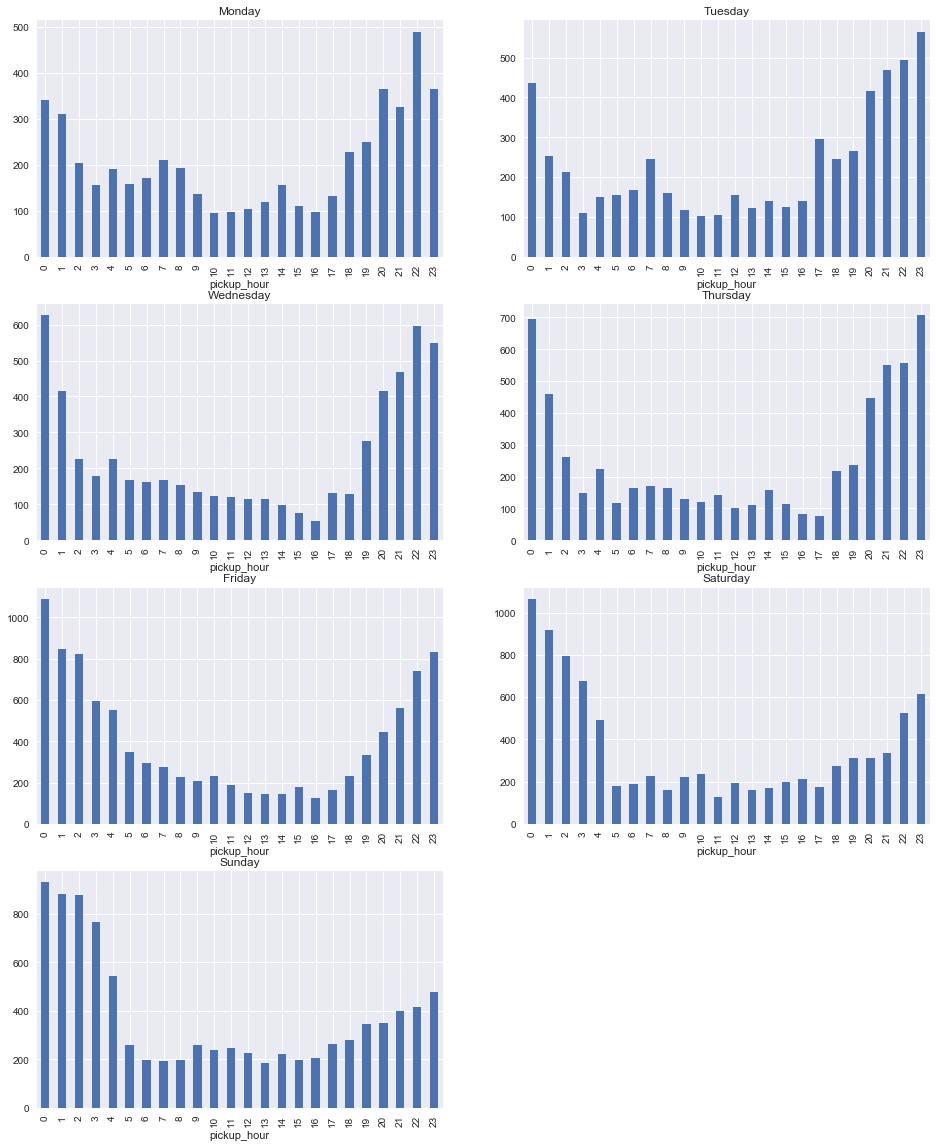

In [94]:
data_astoria_manhattan = passenger_count_hourly(a,manhattan)+passenger_count_hourly(manhattan,a)
f=plt.figure(figsize=(16,20))
for i in range(len(wd)):
    ax = f.add_subplot(4,2,i+1)
    ax = data_astoria_manhattan[wd[i]].plot.bar()
    plt.title(wd[i])

Let's plot the overall hourly pickup passenger counts from Astoria to any destination.

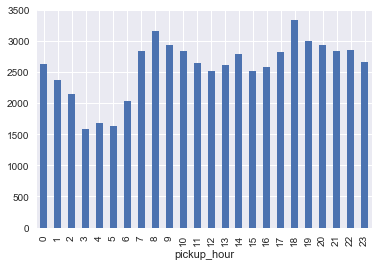

In [89]:
pickup_astoria = data.groupby(['pickup_neighbourhood', 'pickup_hour'])['passenger_count'].sum()
pickup_astoria[a].plot.bar()